# Differential Equations II: Predator/Prey Modeling
### <i>Implemented in RStan</i>

<i>Patrick White</i></br>
<i>Dec 27, 2024</i>

<img src="img/de2.png" style="height: 400px; width:auto;">

# Outline

- Recap
- The Lotka-Volterra Equations
- The Lynx and Hare Pelts Dataset
- Exploratory Data Analysis
- Implementation
- Visualizing the Results
- What’s Next?

# Recap

The last article introduced differential equations as equations, or systems of equations, that associate a function with one or more derivatives. They arise when it is easier to describe change than absolute amounts, and often involve finding a function whose derivative is defined in terms of the function itself. A differential equation defined in terms of derivatives of single variables, as opposed to partial derivatives, is called an ordinary differential equations (ODEs).

ODEs are particularly good at describing dynamics of a system over time, when that system can be represented as compartments whose changes in volume are related to each other’s current state. For example, in the next article we will focus on outbreak modeling through sizes of susceptible, infected, and recovered populations over time. In this article, we will examine predator/prey dynamics through the Lotka-Volterra system of ODEs.

The Lotka-Volterra equations model the temporal dynamics of two species, $x$ and $y$, in terms of four parameters: $\alpha$, $\beta$, $\gamma$, and $\delta$. The prey species is represented by $x$ and the predator by $y$.

$\frac{dx}{dt} = x(\alpha - \beta y) = \alpha x + \beta xy$

$\frac{dy}{dt} = y(- \gamma + \delta x) = - \gamma y + \delta xy$

- $x$ and $y$ are shorthand for $x(t)$ and $y(t)$, the prey and predator populations respectively at time $t$

- $\alpha$ represents the intrinsic growth rate of the prey $x$ in the absence of interaction with the predator $y$

- $− \gamma$ represents the attrition rate of predator $y$ in the absence of prey species $x$

- $\beta_{xy}$ represents the number of the prey population killed by the predator population

- $\delta_{xy}$ represents the growth of the predator population as a result of consuming the prey

The rate of growth of the prey population is proportional to the size of the prey population, leading to exponential growth if unchecked. The predator population shrinks at a rate proportional to the product of its size and they prey population's size. Together, these lead to a cycle of rising and falling populations.

# The Lynx and Hare Pelts Dataset

A famous predator/prey dynamics dataset is based upon the numbers of Snowshoe Hare and Canadian Lynx pelts collected by the Hudson’s Bay Company over a number of years in the early 20th century. The first year available is 1900 and the last year available is 1920. We will use the number of pelts over time as a proxy for the population sizes, and determine the parameter values which best fit the Lotka-Volterra equations to the data.

We’ll be using the sampler Stan through the R interface provided by RStan, so I will import the R libraries we will be using along with the data.

In [ ]:
# install.packages('reshape')
# install.packages('rstan')
library(ggplot2)
library(reshape)
library(rstan)

In [2]:
data <-
read.csv("https://raw.githubusercontent.com/pw598/Articles/refs/heads/main/data/lynxhare.csv")[,2:4]
head(data)

,Year,Lynx,Hare
,<int>,<dbl>,<dbl>
1,1900,4.0,30.0
2,1901,6.1,47.2
3,1902,9.8,70.2
4,1903,35.2,77.4
5,1904,59.4,36.3
6,1905,41.7,20.6


# Exploratory Data Analysis

Let’s visualize the data, first as a time series.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


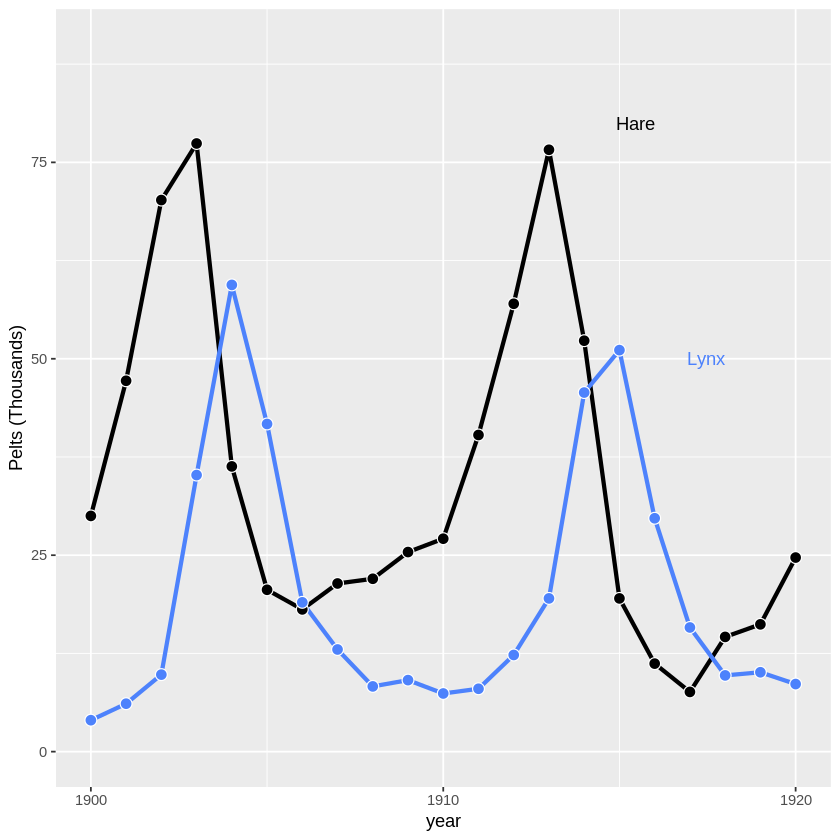

In [3]:
data$Index <- 1:21
ggplot(data, aes(x=Index)) +
  geom_line(aes(y=Hare), linewidth=1.2) +
  geom_line(aes(y=Lynx), color="#4D82FC", size=1.2) +
  geom_point(aes(y=Hare), color="white", fill="black", shape=21, size=3) +
  geom_point(aes(y=Lynx), color="white", fill="#4D82FC", shape=21, size=3) +
  scale_y_continuous(limits=c(0, 90), name="Pelts (Thousands)") +
  scale_x_continuous(breaks=c(1, 11, 21), labels=data$Year[c(1, 11, 21)], name="year") +
  annotate("text", x=17, y=80, label="Hare", hjust=1) +
  annotate("text", x=19, y=50, label="Lynx", color="#4D82FC", hjust=1)

We can also show a 'phase-portrait', also known as a state-space trajectory. The x-axis is Lynx pelts and the y-axis is Hare pelts. The line in the graph traces the trajectory of the data from the starting time point to the ending time point, and because of the cyclical (and related) behavior of the two species, we see circles in the state-space trajectory. To distinguish one cycle from another, we color-code the time dimension into the line.

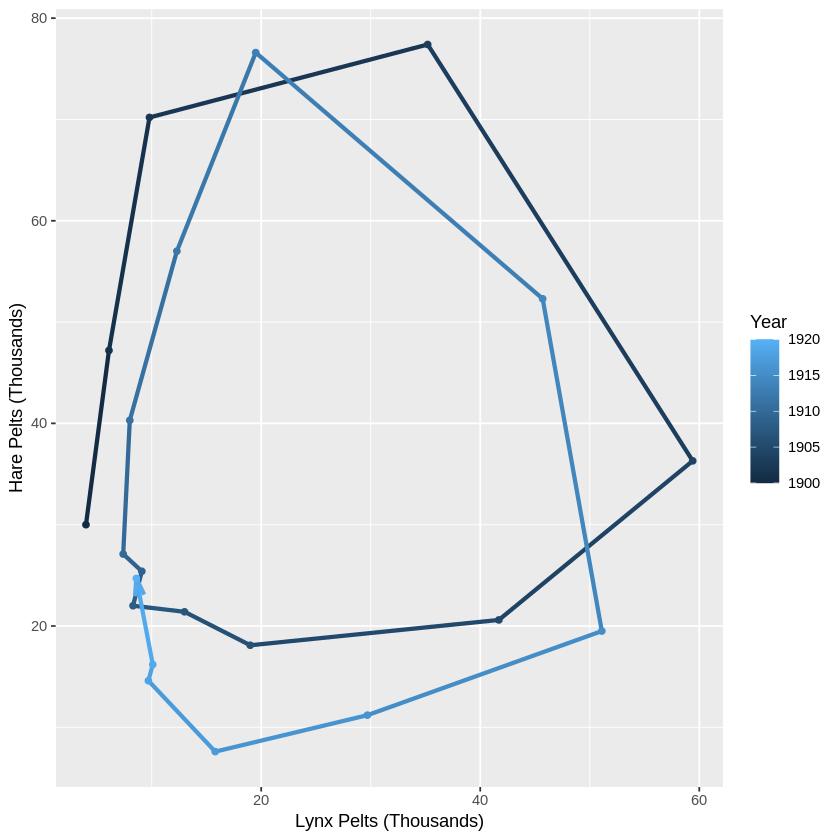

In [4]:
ggplot(data = data,
       aes(x = Lynx, y = Hare, color = Year)) +
geom_path(arrow = arrow(angle = 15, length = unit(0.15, "inches")), linewidth=1.2) +
geom_point(size = 1.5) +
xlab("Lynx Pelts (Thousands)") +
ylab("Hare Pelts (Thousands)")

# Implementation

In the previous article, we found point-form estimates of parameter values, whereas in this one, we will use the probabilistic programming language Stan to incorporate randomness or uncertainty. This can be preferable when dealing with noisy or incomplete data. As in Bayesian modeling, it will involve coding our prior expectations, so as to eliminate highly unlikely outcomes.

Stan solves for $y(t,θ)$ at a sequence of times $t_1, t_2, \ldots, t_N$ in the ODE initial value problem defined by:

$y(t, \theta)' = f(t, y, \theta)$

$y(t=t_0, \theta) = y_0$

- $y(t,θ)$ is the state

- $f(t,y,θ)$ is the ODE system function

- $t_0$ are the initial conditions

To specify an ODE in Stan, we first code $f$ in the functions{} block, observing a strict signature:

<code>real[] f(real time, real[] state, real[] theta, real[] x_r, int[] x_i)</code>

- <code>time</code> represents the observed times at which measurements were made.

- <code>state</code>, which we'll label <code>z</code>, represents the populations of each species.

- <code>theta</code> represents the variables used to compute <code>f</code>, which depend on the model parameters

- <code>x_r</code> are real variables used to evaluate <code>f</code>, which only depend on fixed data

- <code>x_i</code> are integer values used to evaluate <code>f</code>, which only depend on fixed data

We then unpack the <code>theta</code> array, labeling elements as <code>alpha</code>, <code>beta</code>, <code>gamma</code>, and <code>delta</code>. Then, we specify the Lotka-Volterra system of equations as

<code>real dx_dt = (alpha - beta * y) * x</code>

and

<code>real dy_dt = (-gamma + delta * x) * y</code>.

Finally, we call upon the function to return the derivatives for both populations.

In [ ]:
# functions {
#   array[] real dz_dt(real t,              // time
#                      array[] real z,      // system state {prey, predator}
#                      array[] real theta,  // parameters
#                      array[] real x_r,    // unused data
#                      array[] int x_i) {
#     real x = z[1];
#     real y = z[2];

#     real alpha = theta[1];
#     real beta = theta[2];
#     real gamma = theta[3];
#     real delta = theta[4];

#     real dx_dt = (alpha - beta * y) * x;
#     real dy_dt = (-gamma + delta * x) * y;
#     return {dx_dt, dy_dt};
#   }
# }

In the <code>data{}</code> block, we specify the names of parameters we want to pass in to the model, including <code>N</code> for the number of measurement times, <code>ts</code> for the measurement times, <code>y_init</code> for the initial populations, and <code>y</code> for the measured populations.

In [ ]:
# data {
#   int<lower=0> N;                  // number of measurement times
#   array[N] real ts;                // measurement times > 0
#   array[2] real y_init;            // initial measured populations
#   array[N, 2] real<lower=0> y;     // measured populations
# }

In the <code>parameters{}</code> block, we define the names of variables we'll need to work with in the sampling process for modeling. This includes our array of coefficients <code>theta</code>, a two-element array expressing the initial populations, <code>z_init</code>, and a scale of measurement error, <code>sigma</code>.

In [ ]:
# parameters {
#   array[4] real<lower=0> theta;    // { alpha, beta, gamma, delta }
#   array[2] real<lower=0> z_init;   // initial population
#   array[2] real<lower=0> sigma;    // measurement errors
# }

Then, in the transformed <code>parameters{}</code> block, we call upon the <code>integrate_ode_rk45()</code> function. This refers to the Runge-Kutta 4th/5th order method of solving. The syntax is as follows:

In [ ]:
# integrate_ode_rk45(system, y0, t0, ts, theta, x_r, x_i, rel_tol, abs_tol, max_num_steps)

In our case, the <code>dz_dt</code> function we defined in the functions block is what defines the <code>system</code> argument. The next two arguments are the initial populations and initial time (0), followed by the observed time points <code>ts</code>, the parameters <code>theta</code>, and values for the relative tolerance (accuracy required for solution), absolute tolerance (allowable error in absolute changes of state variables), and maximum number of steps the solver may take between any two time points in <code>ts</code>.

In [ ]:
# transformed parameters {
#   array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
#                                           rep_array(0.0, 0), rep_array(
#                                           0, 0), 1e-5, 1e-3, 5e2);
# }

In the <code>model{}</code> block, we set reasonable priors that will help to rule out unreasonable parameter values. We use normal priors on the parameters enclosed in <code>theta</code>, but lognormal priors on the other variables such as <code>sigma</code> and <code>y</code> because errors will be multiplicative, according to the equations. In the <code>generated quantities{}</code> block, we tell <code>stan</code> to retain samples for the <code>y_init</code> and <code>y</code> variable, as <code>y_rep</code>, for us to draw from the posterior distribution.

In [ ]:
# model {
#   theta[{1, 3}] ~ normal(1, 0.5);
#   theta[{2, 4}] ~ normal(0.05, 0.05);
#   sigma ~ lognormal(-1, 1);
#   z_init ~ lognormal(log(10), 1);
#   for (k in 1 : 2) {
#     y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
#     y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
#   }
# }

# generated quantities {
#   array[2] real y_init_rep;
#   array[N, 2] real y_rep;
#   for (k in 1 : 2) {
#     y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
#     for (n in 1 : N) {
#       y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
#     }
#   }
# }

Putting it all together:

In [5]:
# adapted from https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html#statistical-model-prior-knowledge-and-unexplained-variation

stan_code <- "

functions {
  array[] real dz_dt(real t,              // time
                     array[] real z,      // system state {prey, predator}
                     array[] real theta,  // parameters
                     array[] real x_r,    // unused data
                     array[] int x_i) {
    real x = z[1];
    real y = z[2];

    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];

    real dx_dt = (alpha - beta * y) * x;
    real dy_dt = (-gamma + delta * x) * y;
    return {dx_dt, dy_dt};
  }
}

data {
  int<lower=0> N;                  // number of measurement times
  array[N] real ts;                // measurement times > 0
  array[2] real y_init;            // initial measured populations
  array[N, 2] real<lower=0> y;     // measured populations
}

parameters {
  array[4] real<lower=0> theta;    // { alpha, beta, gamma, delta }
  array[2] real<lower=0> z_init;   // initial population
  array[2] real<lower=0> sigma;    // measurement errors
}

transformed parameters {
  array[N, 2] real z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                                          rep_array(0.0, 0), rep_array(
                                          0, 0), 1e-5, 1e-3, 5e2);
}

model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1 : 2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ : , k] ~ lognormal(log(z[ : , k]), sigma[k]);
  }
}

generated quantities {
  array[2] real y_init_rep;
  array[N, 2] real y_rep;
  for (k in 1 : 2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1 : N) {
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
    }
  }
}
"

We run the model,

In [ ]:
N <- length(data$Year) - 1
ts <- 1:N
y_init <- c(data$Hare[1], data$Lynx[1])
y <- as.matrix(data[2:(N + 1), 2:3])
y <- cbind(y[ ,2], y[ ,1]); # hare, lynx order
data_list <- list(N = N, ts = ts, y_init = y_init, y = y)

model_fit <- stan(model_code = stan_code, data = data_list, verbose=0)

Inspect the results in terms of parameters,

In [7]:
print(model_fit, pars=c("theta", "sigma", "z_init"),
      probs=c(0.1, 0.5, 0.9), digits = 3)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean    sd    10%    50%    90% n_eff  Rhat
theta[1]   0.546   0.002 0.065  0.467  0.541  0.629   901 1.008
theta[2]   0.028   0.000 0.004  0.023  0.027  0.033   942 1.008
theta[3]   0.803   0.003 0.092  0.691  0.797  0.920   896 1.007
theta[4]   0.024   0.000 0.004  0.020  0.024  0.029   940 1.007
sigma[1]   0.249   0.001 0.043  0.199  0.245  0.301  2599 1.000
sigma[2]   0.252   0.001 0.045  0.201  0.246  0.312  2622 1.000
z_init[1] 34.005   0.055 2.910 30.445 33.945 37.715  2761 1.001
z_init[2]  5.927   0.012 0.528  5.282  5.904  6.615  2011 1.001

Samples were drawn using NUTS(diag_e) at Sat Dec 28 20:43:56 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Recall from the code that <code>alpha</code>, <code>beta</code>, <code>gamma</code>, and <code>delta</code> are represented by <code>theta[1]</code>, <code>theta[2]</code>, <code>theta[3]</code>, and <code>theta[4]</code> respectively.

We then run some sampling diagnostics,

'pars' not specified. Showing first 10 parameters by default.



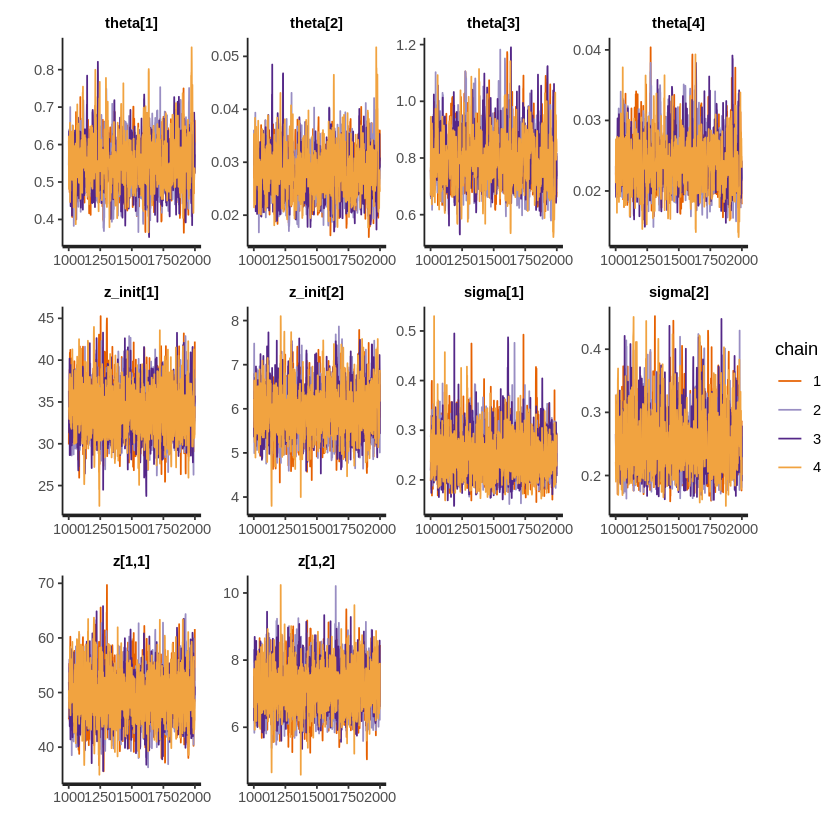

In [8]:
traceplot(model_fit)

'pars' not specified. Showing first 10 parameters by default.



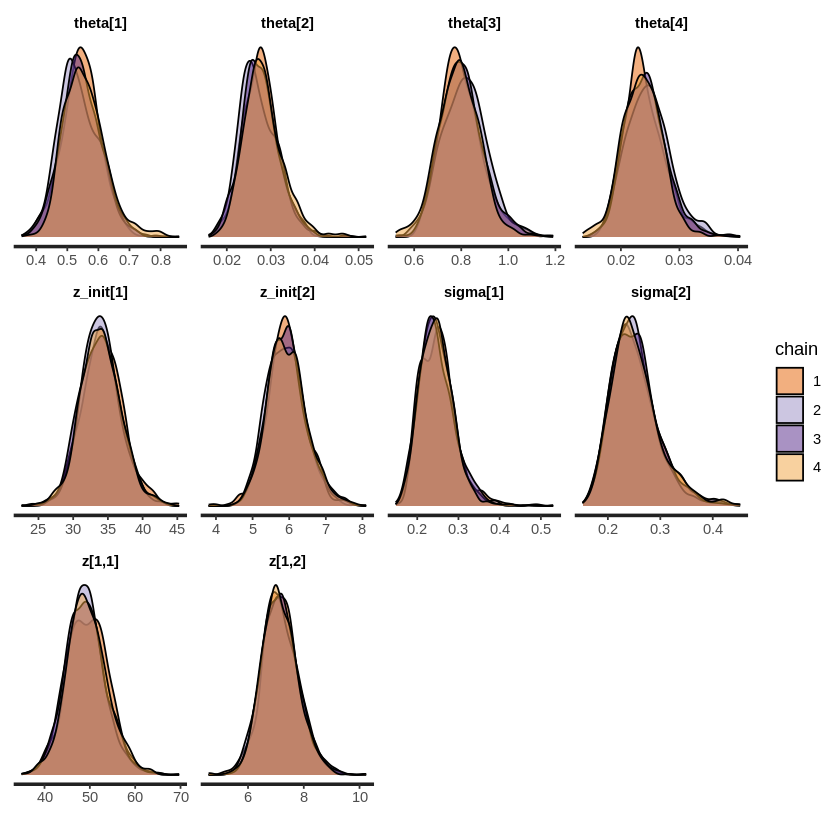

In [9]:
stan_dens(model_fit, separate_chains = TRUE)

# Visualizing the Results

We now extract the posterior samples and plot the results (drawing a subsample).

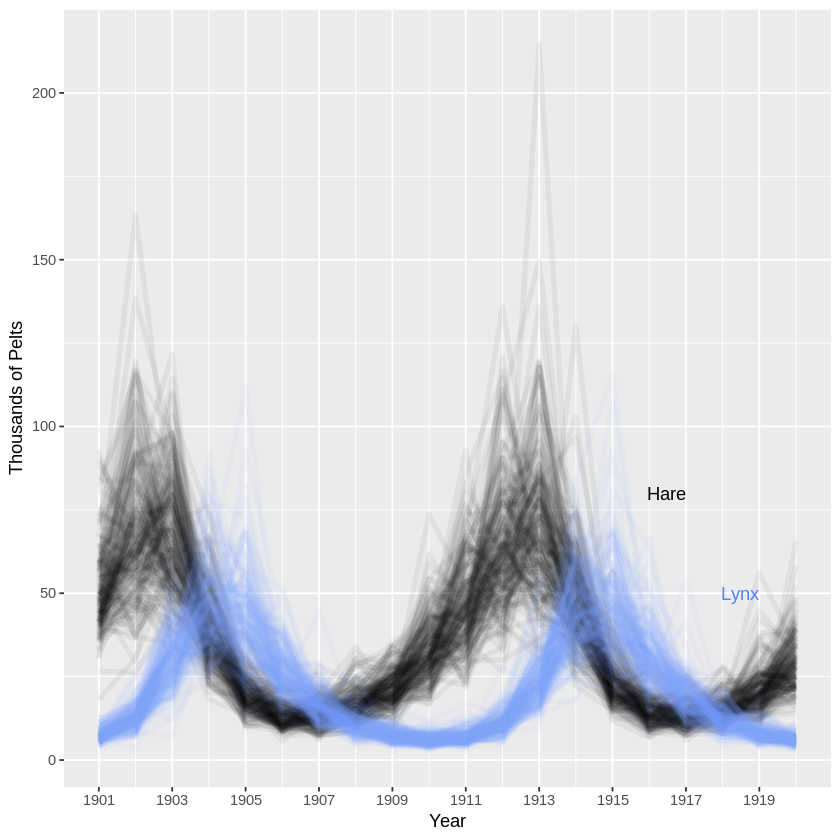

In [10]:
posterior_samples <- na.omit(extract(model_fit))

sampled_indices <- sample(1:4000, 200)
sampled_data <- posterior_samples$y_rep[sampled_indices, , ]

years <- 1901:1920
sample_indices <- 1:200

df <- data.frame(
  year = seq(1901:1920),
  sample = rep(sample_indices, each = length(years)),
  pelt_type = rep(c("pelt_type_1", "pelt_type_2"), each = length(years) * length(sample_indices)),
  value = NA
)

for (s in sample_indices) {
  df$value[df$sample == s & df$pelt_type == "pelt_type_1"] <- sampled_data[s, , 1]
  df$value[df$sample == s & df$pelt_type == "pelt_type_2"] <- sampled_data[s, , 2]
}

ggplot(df, aes(x = year, y = value, group = interaction(sample, pelt_type), color = pelt_type)) +
  geom_line(alpha = 0.05, size = 1.5) +
  scale_color_manual(values = c("black", rgb(125/255, 165/255, 255/255))) +
  labs(x = "Year", y = "Thousands of Pelts") +
  annotate("text", x=17, y=80, label="Hare", hjust=1) +
  annotate("text", x=19, y=50, label="Lynx", color="#4D82FC", hjust=1) +
  scale_x_continuous(
    breaks = seq(1, 20, by = 2),
    labels = seq(1901, 1920, by = 2),
    limits = c(1, 20)
  ) +
  theme(legend.position = "none")

We can also do a phase portrait for posterior samples:

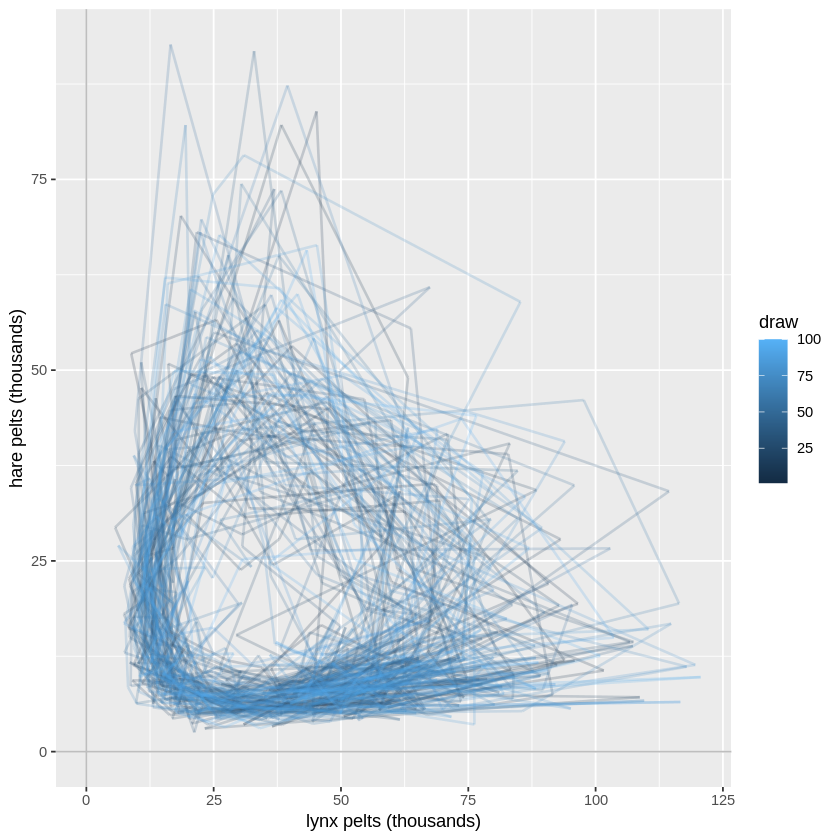

In [11]:
df <- data.frame(list(lynx = sampled_data[1, 1:12 , 1], hare = sampled_data[1, 1:12, 2], draw = 1))
for (m in 2:100) {
  df <- rbind(df, data.frame(list(lynx = sampled_data[m, 1:12 , 1], hare = sampled_data[m, 1:12, 2], draw = m)))
}
plot <- ggplot(df) +
  geom_vline(xintercept = 0, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  geom_path(aes(x = lynx, y = hare, colour = draw), linewidth = 0.75, alpha = 0.2) +
  xlab("lynx pelts (thousands)") +
  ylab("hare pelts (thousands)")
plot

The multiplicative error can lead to somewhat spiky behavior, especially at lower level of granularity (such as by year).

In the following, we visualize the measured vs. predicted values for each species, filling in the interquartile range around the predictions as an HDI (highest density interval).

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


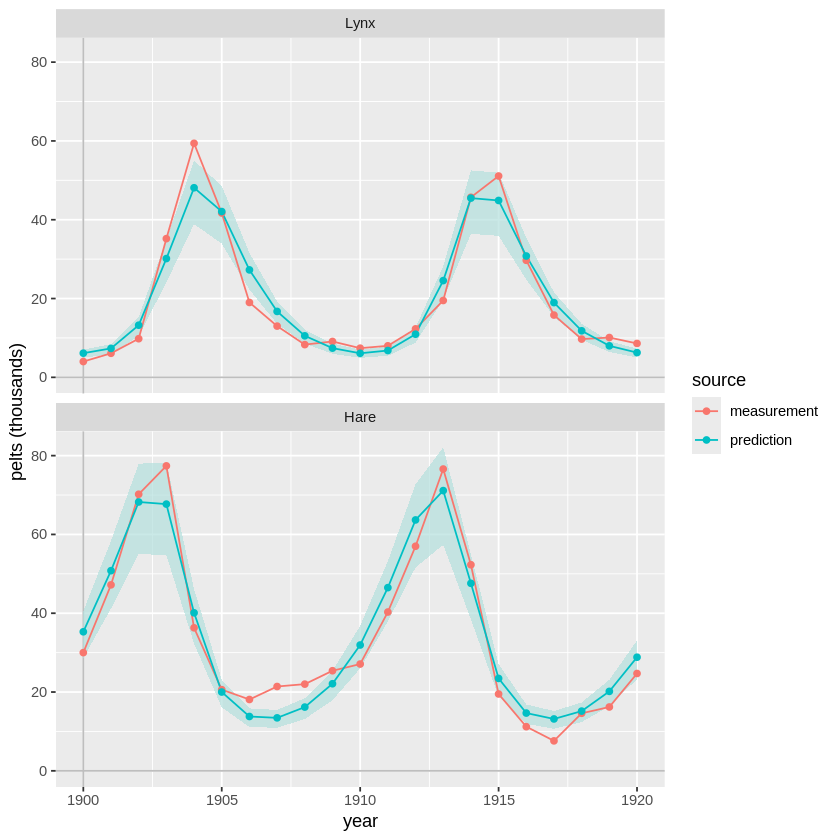

In [12]:
# adapted from https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html#statistical-model-prior-knowledge-and-unexplained-variation

lynx_hare_melted_df <- melt(as.matrix(data[, 2:3]), as.is = TRUE)
colnames(lynx_hare_melted_df) <- c("year", "species", "pelts")
lynx_hare_melted_df$year <-
  lynx_hare_melted_df$year +
  rep(1899, length(lynx_hare_melted_df$year))

z_init_draws <- extract(model_fit)$z_init
z_draws <- extract(model_fit)$z
y_init_rep_draws <- extract(model_fit)$y_init_rep
y_rep_draws <- extract(model_fit)$y_rep
predicted_pelts <- matrix(NA, 21, 2)
min_pelts <- matrix(NA, 21, 2)
max_pelts <- matrix(NA, 21, 2)
for (k in 1:2) {
  predicted_pelts[1, k] <- mean(y_init_rep_draws[ , k])
  min_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.25)
  max_pelts[1, k] <- quantile(y_init_rep_draws[ , k], 0.75)
  for (n in 2:21) {
    predicted_pelts[n, k] <- mean(y_rep_draws[ , n - 1, k])
    min_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.25)
    max_pelts[n, k] <- quantile(y_rep_draws[ , n - 1, k], 0.75)
  }
}

Nmelt <- dim(lynx_hare_melted_df)[1]
lynx_hare_observe_df <- lynx_hare_melted_df
lynx_hare_observe_df$source <- rep("measurement", Nmelt)

lynx_hare_predict_df <-
  data.frame(year = rep(1900:1920, 2),
             species = c(rep("Lynx", 21), rep("Hare", 21)),
             pelts = c(predicted_pelts[, 2],
                       predicted_pelts[, 1]),
             min_pelts = c(min_pelts[, 2], min_pelts[, 1]),
             max_pelts = c(max_pelts[, 2], max_pelts[, 1]),
             source = rep("prediction", 42))

lynx_hare_observe_df$min_pelts = lynx_hare_predict_df$min_pelts
lynx_hare_observe_df$max_pelts = lynx_hare_predict_df$max_pelts

lynx_hare_observe_predict_df <-
  rbind(lynx_hare_observe_df, lynx_hare_predict_df)

population_plot2 <-
  ggplot(data = lynx_hare_observe_predict_df,
         aes(x = year, y = pelts, color = source)) +
  geom_vline(xintercept = 1900, color = "grey") +
  geom_hline(yintercept = 0, color = "grey") +
  facet_wrap( ~ species, ncol = 1) +
  geom_ribbon(aes(ymin = min_pelts, ymax = max_pelts),
	      colour = NA, fill = "#b3e0dc", alpha = 0.7) +
  geom_line() +
  geom_point() +
  ylab("pelts (thousands)")

population_plot2

# What’s Next?

That’s it for this article, but the next one will deal with a similar concept, outbreak modeling through a system of ODEs using the susceptible, infected, recovered (SIR) model.

# References

- McElreath, R. (2017). Statistical Rethinking (2nd ed.). https://github.com/Booleans/statistical-rethinking/blob/master/Statistical%20Rethinking%202nd%20Edition.pdf

- <a href="https://www.youtube.com/watch?v=FdnMWdICdRs&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus">Richard McElreath (Statistical Rethinking) Lectures</a>

- Carpenter, B. (2018). Predator-Prey Population Dynamics: The Lotka-Volterra model in Stan. Stan Case Studies. https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html#statistical-model-prior-knowledge-and-unexplained-variation

- (n.d.). Hare and Lynx Population Dynamics. https://colab.research.google.com/github/ndcbe/controls/blob/main/notebooks/02.08-Hare-and-Lynx.ipynb

- Stan Users Guide, Ordinary Differential Equations. https://mc-stan.org/docs/stan-users-guide/odes.html

- Bales, B., & Weber, S. (2020). Upgrading to the new ODE interface. https://mc-stan.org/users/documentation/case-studies/convert_odes.html